## Database

In [ ]:
from __future__ import absolute_import, division, print_function

import sys
import os
import time
import pickle
from math import ceil, floor, sqrt

sys.path.insert(0,'../../')
sys.path.insert(0,'../../../py')

import parameters
import utilities
import output_utilities
from spectrogram_utilities import spectrogram_plot, spectrogram_reshape, spectrogram_hist
from spectrogram_output_visualiser import spectrogram_and_output, spectrogram_cut, spectrogram_cut_augmented
import spectrogram_cuts_db_creation


import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from IPython.display import Image

import tensorflow as tf

from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model

# matplotlib.get_backend()
%matplotlib inline

# constants
awd_event = 1
site = parameters.sites[0]

# use gpu
print('GPUs:',K.tensorflow_backend._get_available_gpus())
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

### Loading H5 files

In [2]:
data, evt = load_spectrogram_cuts_h5py(awd_event, site, verbose=True)


Loading spectrogram cuts from training database for awdEvent1/marion
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 1184.92 seconds


In [3]:
print(data.shape, evt.shape)

# suffle data
data = list(zip(data,evt))
np.random.seed(7)
np.random.shuffle(data)
np.random.seed(23)
np.random.shuffle(data)
data, evt = zip(*data)
data = np.array(data)
evt = np.array(evt)

data = data.reshape(len(data), parameters.clf_input_width*parameters.clf_input_height)
print(data.shape, evt.shape)

# scale data
scaler = preprocessing.StandardScaler().fit(data)
# save scaler
standard_scaler = {"scaler": scaler}
pickle.dump( standard_scaler, open( 'scaler.pickle', "wb" ) )
# scale data
data = scaler.transform(data)

# reshape for CNN
data = data.reshape((len(data),parameters.clf_input_depth,
              parameters.clf_input_width,
              parameters.clf_input_height))
evt = np_utils.to_categorical(evt)

print(data.shape, evt.shape)

(87211, 128, 128) (87211,)
(87211, 16384) (87211,)
(87211, 1, 128, 128) (87211, 2)


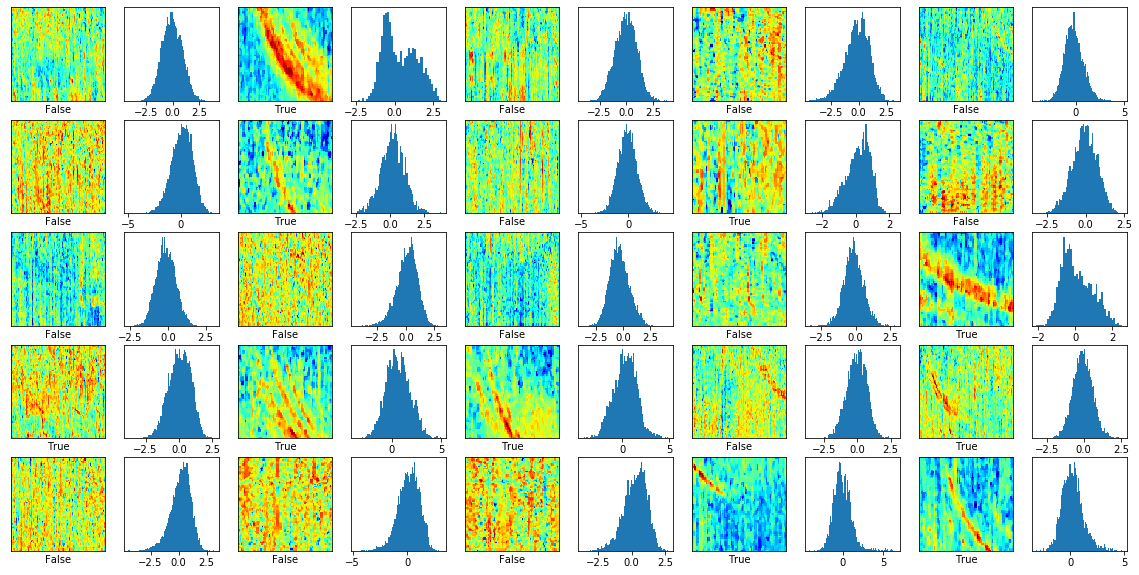

In [4]:
plt.figure(figsize=(10*2,10))
for i in range(0,25*2,2):
    k = np.random.randint(len(data))
    plt.subplot(5,5*2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.pcolormesh(data[i][0], cmap='jet')
    plt.xlabel(np.bool_(evt[i][1]))    
    plt.subplot(5,5*2,i+2)
    plt.yticks([])
    plt.grid(False)
    plt.hist(data[i][0].flatten(), bins='auto')
#     plt.xlabel(np.bool_(evt[i][1]))
#     spectrogram_plot(data[k][0])
plt.show()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 4, 128, 128)       4100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 128, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 128, 128)       8200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 128, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 128, 128)      8208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 64, 64)         131074    
__________

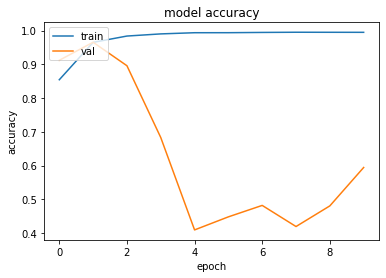

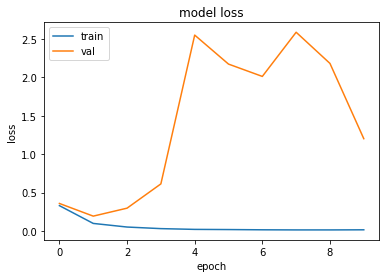

In [5]:
def create_model():
    # create the model
    model = Sequential()
    model.add(Conv2D(4,(32,32), input_shape=(parameters.clf_input_depth,parameters.clf_input_width, parameters.clf_input_height),
                    padding='same', activation='relu',data_format='channels_first'))
    model.add(Dropout(0.6))
    model.add(Conv2D(8, (16,16), activation='relu', padding='same',data_format='channels_first'))
    model.add(Dropout(0.7))
    model.add(Conv2D(16, (8,8), activation='relu', padding='same',data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
#     model.add(Conv2D(16, (3,3), activation='relu', padding='same',data_format='channels_first'))
    model.add(Conv2D(2, (64,64), activation='relu', padding='same',data_format='channels_first'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(2, activation='softmax'))

    # compile model
    epochs = 25
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    adam = Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    print(model.summary())
    return model
# model = KerasClassifier(build_fn=createhttps://readms.net/_model)
model = create_model()

history = model.fit(data, evt, validation_split=0.5, epochs=10, batch_size=250, shuffle=False)

print(history.history.keys())
# summarize history for accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

model.save('cnn.h5')

In [6]:
# from keras.models import load_model

# def model_get_conv_layers(model):
#     layers = []
#     # summarize filter shapes
#     for layer in model.layers:
#         # check for convolutional layer
#         if 'conv' not in layer.name:
#             continue
#         # get filter weights
#         layers.append(layer)
#     return layers

# def model_visualization(model, summary=False, plot=False, conv_layer_number=0):
#     '''Visualize the CNN model'''
#     if summary:
#         print(model.summary())
#     if plot:
#         plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
#         Image(retina=True, filename='model.png')
#     # get filers and biases
#     filters, biases = model_get_conv_layers(model)[conv_layer_number].get_weights()
#     # scale filters
#     f_min, f_max = filters.min(), filters.max()
#     filters = (filters-f_min)/(f_max-f_min)
#     # get number of filters
#     n_filters, ix = filters.shape[-1], 1

#     for i in range(n_filters):
#         # get the filters
#         f = filters[:,:,:,i]
#         # plot each channel seperately
#         for j in range(1):
#             # specify subplot and turn of axis
#             ax = plt.subplot(1,n_filters, ix)
#             ax.set_xticks([])
#             ax.set_yticks([])
#             # plot filter channel in grayscale
#             plt.imshow(f[:, :, j], cmap='jet')
#             ix += 1
#     plt.show()
    
# _model = load_model('cnn.h5')

# model_visualization(_model, conv_layer_number=0)

In [ ]:
# from keras.models import Model
# _model = load_model('cnn.h5')
# _model = Model(inputs=_model.inputs, outputs=_model.layers[0].output)
# print(_model.summary())
# k = np.random.randint(len(data))
# example = np.array([data[k]])
# feature_maps = _model.predict(example)
# print(feature_maps.shape)
# plt.figure()
# plt.imshow(example[0][0], cmap='jet')
# plt.figure()
# for i in range(feature_maps.shape[1]):
#     ax = plt.subplot(1,feature_maps.shape[1],i+1)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     plt.imshow(feature_maps[0, i, :, :], cmap='jet')

In [8]:
# _data, _evt = load_spectrogram_cuts_h5py(awd_event, site, verbose=True, partition='testing')
# _data = _data.reshape(len(_data), parameters.clf_input_width*parameters.clf_input_height)
# _data = scaler.transform(_data)

# _data = _data.reshape((len(_data),parameters.clf_input_depth,
#               parameters.clf_input_width,
#               parameters.clf_input_height))

# _evt = np_utils.to_categorical(_evt)

pred = model.predict(data, batch_size=50)
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(evt.argmax(axis=-1), pred.argmax(axis=-1))))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(evt.argmax(axis=-1), pred.argmax(axis=-1)))

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7f45e87816a0>:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     11587
           1       1.00      0.91      0.95      7125

    accuracy                           0.96     18712
   macro avg       0.97      0.95      0.96     18712
weighted avg       0.97      0.96      0.96     18712


Confusion matrix:
[[11575    12]
 [  664  6461]]


PRE-PROCESSED SAMPLE SHOWING CUT USED BY DETECTOR


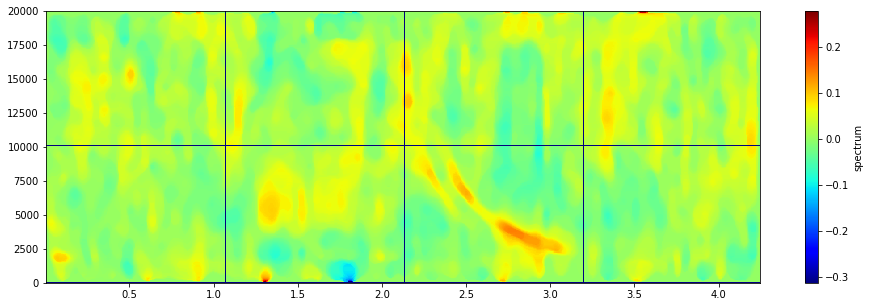

CLASSIFICATION OF CUTS USED BY DETECTOR


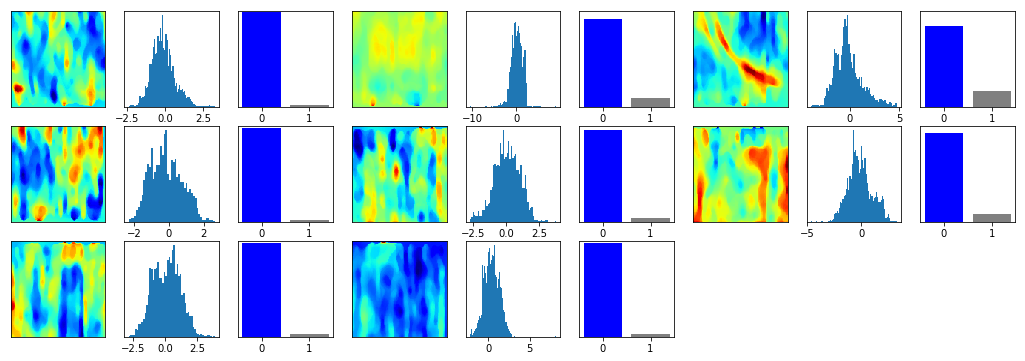

In [24]:
from math import ceil, sqrt
from spectrogram_utilities import spectrogram_plot, spectrogram_reshape, spectrogram_hist
from spectrogram_output_visualiser import spectrogram_and_output, spectrogram_cut, spectrogram_cut_augmented
dic = pickle.load(open( os.path.join(parameters.hyp5_location,'awdEvents'+str(awd_event), site,'h5py_cuts','spectrogram_cuts.pickle'), "rb" ) )

files = dic["training"]
file = files[np.random.randint(len(files))]

width = 4
heigth = 2
_, time, freq, spectrogram_pro = spectrogram_and_output(awd_event, site, file, output=False, zscore=True, medfilt=True, method="normalize")
# plot detector results
spec ,indices, detector_cuts = spectrogram_split(spectrogram_pro, width, heigth)
print("PRE-PROCESSED SAMPLE SHOWING CUT USED BY DETECTOR")
_ = spectrogram_plot(spec, xaxis=time, yaxis=freq, size=(16,5))

y_size = ceil(sqrt(len(detector_cuts)))
x_size = ceil(len(detector_cuts)/y_size)
print("CLASSIFICATION OF CUTS USED BY DETECTOR")
plt.figure(figsize=(y_size*2*3,x_size*2))
for i in range(0,len(detector_cuts)*3,3):
    plt.subplot(x_size, y_size*3,i+1)
    index = int(i/3)
    spec = detector_cuts[index]
    spec = spectrogram_reshape(spec)
    spec = scaler.transform(spec.reshape(parameters.clf_input_depth,parameters.clf_input_width*parameters.clf_input_height))
    spec = spec.reshape(1,parameters.clf_input_depth,parameters.clf_input_width,parameters.clf_input_height)
    pred = model.predict(spec)[0]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.pcolormesh(spec[0][0], cmap='jet')
    plt.subplot(x_size, y_size*3, i+2)
    plt.yticks([])
    plt.hist(spec[0][0].flatten(), bins='auto')
    plt.subplot(x_size, y_size*3, i+3)
    plt.yticks([])
    _range = np.arange(len(pred))
    plt.bar(_range[np.isin(pred, pred.min())], pred[np.isin(pred, pred.min())], color="gray")
    plt.bar(_range[np.isin(pred, pred.max())], pred[np.isin(pred, pred.max())], color="blue")
    plt.ylim([0, 1])
plt.show()

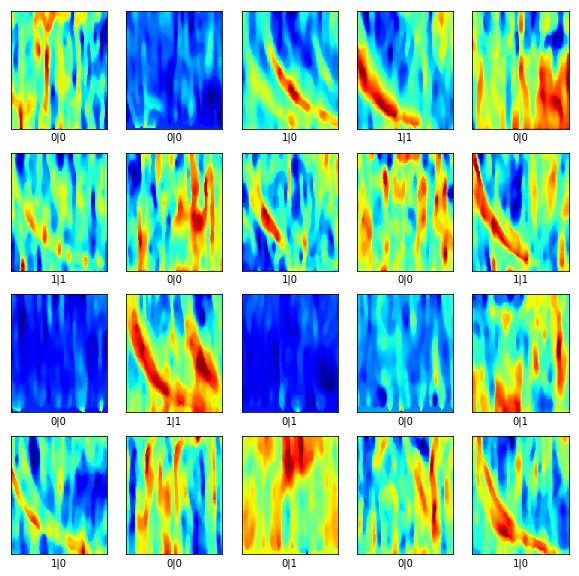

In [11]:
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    k = np.random.randint(len(_data))
    plt.pcolormesh(_data[k][0], cmap='jet')
    plt.xlabel(str(pred[k].argmax(axis=-1))+'|'+str(evt[k].argmax(axis=-1)))
plt.show()
# pred = np.argmax(predictions, axis=1)

# print("Classification report for classifier %s:\n%s\n"
#       % (model, metrics.classification_report(evt, pred)))
# print("Confusion matrix:\n%s" % metrics.confusion_matrix(evt, pred))

In [10]:
def spectrogram_split(spectrogram, width, height):
    '''Split the spectrogram according to width and height'''
    # mark the cut in the spectrogram
    spec = spectrogram.copy()
    f_max, t_max = spec.shape
    t_index = np.array(list(range(0, t_max, ceil(t_max/width))))
    f_index = np.array(list(range(0, f_max, ceil(f_max/heigth))))
    for t in t_index:
        spec[:,t] = np.full(spec[:,0].shape, spec.min())
    for f in f_index:
        spec[f,:] = np.full(spec[0,:].shape, spec.min())
    # extract the cuts
    cuts = []
    indices = []
    for f in range(len(f_index)):
        for t in range(len(t_index)):
            if t < len(t_index)-1 and f<len(f_index)-1:
                cuts.append(spectrogram_reshape(spectrogram[f_index[f]:f_index[f+1],t_index[t]:t_index[t+1]]))
                indices.append([t_index[t],t_index[t+1],f_index[f],f_index[f+1]])
            elif f == len(f_index)-1 and t < len(t_index)-1:
                cuts.append(spectrogram_reshape(spectrogram[f_index[f]:f_max,t_index[t]:t_index[t+1]]))
                indices.append([t_index[t],t_index[t+1],f_index[f],f_max])
            elif t==len(t_index)-1 and f < len(f_index)-1:
                cuts.append(spectrogram_reshape(spectrogram[f_index[f]:f_index[f+1],t_index[t]:t_max]))
                indices.append([t_index[t],t_max,f_index[f],f_index[f+1]])
            else:
                cuts.append(spectrogram_reshape(spectrogram[f_index[f]:f_max,t_index[t]:t_max]))
                indices.append([t_index[t],t_max,f_index[f],f_max])
    cuts = np.array(cuts)
    
    return spec, indices, cuts